# Decision tree classifier: diabetes prediction

## 1. Data acquisition

### 1.1. Load

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, ShuffleSplit

# Set random seed for notebook
random_seed=1234

# Set train-test split fraction
testing_fraction=0.2

# Cross-validation method - make sure to set random seed to 'None'. Otherwise
# we will generate the same split for each repetition every time we call
cv_method=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=None)

# Class weighting for decision trees
class_weights=None

# Load the data from the URL
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
data_df.drop_duplicates().reset_index(drop=True, inplace=True)

### 1.2. Train-test split

In [2]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing, setting the random seed
# so that we get the same test-train split every time we run the notebook
training_df, testing_df=train_test_split(
    data_df,
    test_size=testing_fraction,
    random_state=random_seed
)

# Reset the indexes
training_df.reset_index(inplace=True, drop=True)
testing_df.reset_index(inplace=True, drop=True)

In [3]:
# Get features and labels
training_labels=training_df['Outcome']
training_features=training_df.drop('Outcome', axis=1)

### 1.3. Inspect the data types

In [4]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 38.5 KB


In [5]:
training_labels.info()

<class 'pandas.core.series.Series'>
RangeIndex: 614 entries, 0 to 613
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
614 non-null    int64
dtypes: int64(1)
memory usage: 4.9 KB


In [6]:
list(training_labels[:10])

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1]

## 3. Baseline decision tree classifier

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments={'Baseline': scores * 100}

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.5 +/- 2.7%



Model is 100.0% accurate on the training data
Fitted tree depth: 14

Feature importances:
 Pregnancies: 0.080
 Glucose: 0.354
 BloodPressure: 0.044
 SkinThickness: 0.063
 Insulin: 0.044
 BMI: 0.160
 DiabetesPedigreeFunction: 0.096
 Age: 0.159



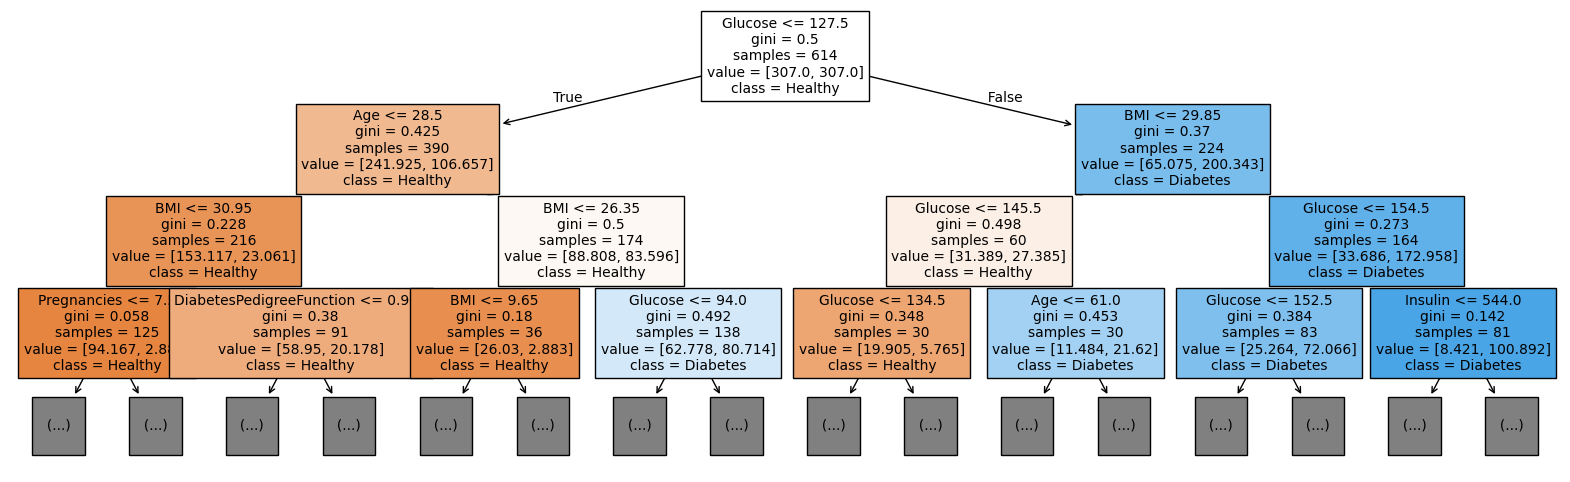

In [8]:
# Let's take a look at the tree
import matplotlib.pyplot as plt
from sklearn import tree

model=DecisionTreeClassifier(random_state=random_seed, class_weight='balanced')
fit_result=model.fit(training_features, training_labels)

# Make predictions from test set features
predicted_labels=model.predict(training_features)

# Score predictions for accuracy
percent_accuracy=accuracy_score(training_labels, predicted_labels) * 100

# Show some details about the model
print(f'\nModel is {percent_accuracy:.1f}% accurate on the training data')
print(f'Fitted tree depth: {fit_result.tree_.max_depth}')
print('\nFeature importances:')

for feature, importance in zip(training_features.columns, fit_result.tree_.compute_feature_importances()):
    print(f' {feature}: {importance:.3f}')

print()

# Plot the first few levels of the tree
fig=plt.figure(figsize=(20,6))

tree.plot_tree(model,
    feature_names=list(training_features.columns),
    class_names=['Healthy', 'Diabetes'],
    filled=True,
    fontsize=10,
    max_depth=3
)

plt.show()

## 2. EDA/feature engineering

### 2.1. Feature distributions

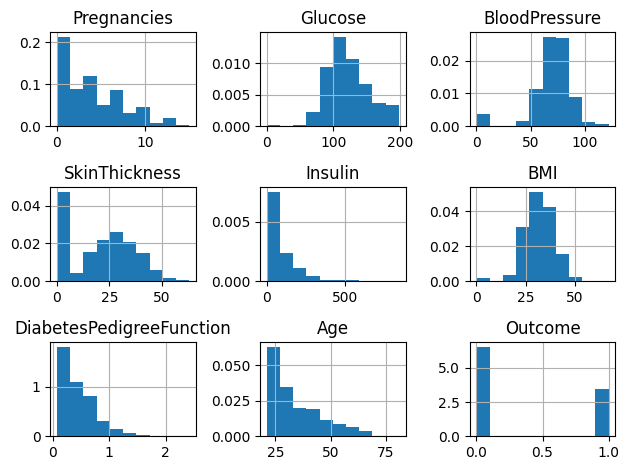

In [9]:
import matplotlib.pyplot as plt

training_df.hist(density=True, layout=(3,3))
plt.tight_layout()
plt.show()

In [10]:
training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.905537,121.061889,69.096091,20.351792,81.135179,31.933550,0.461671,33.537459,0.346906
std,3.423010,31.880426,19.540285,15.757854,116.351466,7.872625,0.317398,11.868683,0.476373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.100000,0.238000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.364500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.500000,0.614750,41.000000,1.000000
max,15.000000,198.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


First weird observation... we have at least one record where everything except DPF and age is zero - I'm pretty sure that someone didn't have zero blood pressure or zero skin thickness! That's probably missing data. Just how much is there?

In [11]:
dead_people=len(training_df[training_df['BloodPressure'] == 0])
print(f'Have {dead_people} people with a blood pressure of 0')

Have 29 people with a blood pressure of 0


### 2.2. Missing values

Ok, if we were to remove rows that contain zero in one of 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' or 'BMI', how much data would we have left?

In [12]:
# Features to look for zeros in
missing_data_features=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# Remove rows that have at least one zeros, using a copy, in case we decide it's a bad idea
filtered_training_df=training_df.copy()
filtered_training_df[missing_data_features]=filtered_training_df[missing_data_features].replace({0:np.nan})
filtered_training_df.dropna(inplace=True)

filtered_training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,3.333333,122.861635,70.814465,29.160377,156.305031,32.978616,0.504770,31.242138,0.333333
std,3.215041,31.011340,12.167606,10.667741,119.975121,7.048295,0.323062,10.547527,0.472147
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.000000,28.400000,0.264750,23.000000,0.000000
50%,2.000000,120.500000,71.000000,29.000000,126.000000,33.200000,0.436500,27.000000,0.000000
75%,5.000000,144.000000,78.000000,37.000000,191.750000,37.075000,0.673750,37.000000,1.000000
max,15.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Wow, ok - so that's almost half of our data! We can't just throw all of those examples away. Let's try a simple imputation for each feature.

#### 2.2.1. Simple imputation

In [13]:
simple_imputed_training_features=training_features.copy()

for target_feature in missing_data_features:

    impute_data=simple_imputed_training_features[simple_imputed_training_features[target_feature] != 0][target_feature]
    target_feature_imputed_value=impute_data.median()
    imputed_data=simple_imputed_training_features[target_feature].replace({0:target_feature_imputed_value})
    simple_imputed_training_features[target_feature]=imputed_data

    print(f'{target_feature} imputed value: {target_feature_imputed_value:.1f}')

simple_imputed_training_features.describe()

Glucose imputed value: 117.0
BloodPressure imputed value: 72.0
SkinThickness imputed value: 29.0
Insulin imputed value: 125.5
BMI imputed value: 32.0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.905537,121.633550,72.496743,28.995114,141.228013,32.350489,0.461671,33.537459
std,3.423010,30.730915,12.032277,8.494599,87.791710,6.963894,0.317398,11.868683
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,25.000000,120.000000,27.400000,0.238000,24.000000
50%,3.000000,117.000000,72.000000,29.000000,125.500000,32.000000,0.364500,29.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.500000,0.614750,41.000000
max,15.000000,198.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


Try the cross-validation again and see how we did.

In [14]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    simple_imputed_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Simple imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 68.3 +/- 3.3%


Maybe slightly better than leaving the zeros in, but close given the variability between cross-validation folds. Let's try a little bit more advanced of an imputation strategy from scikit-learn:

#### 2.2.2. Scikit-learn IterativeImputer

In [15]:
from utils import impute 

imputed_training_features=impute(training_features, missing_data_features)

[IterativeImputer] Completing matrix with shape (614, 8)
[IterativeImputer] Completing matrix with shape (614, 8)


In [16]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    imputed_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Iterative imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 69.7 +/- 2.7%


Again, maybe a bit better, but not strikingly so. Although, the variability between cross-validation folds did go down a little.

### 2.3. Feature selection

In [17]:
from sklearn.feature_selection import RFECV

min_features_to_select=1
clf=DecisionTreeClassifier(random_state=random_seed)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(7),
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=-1
)

rfecv.fit(training_features, training_labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 8


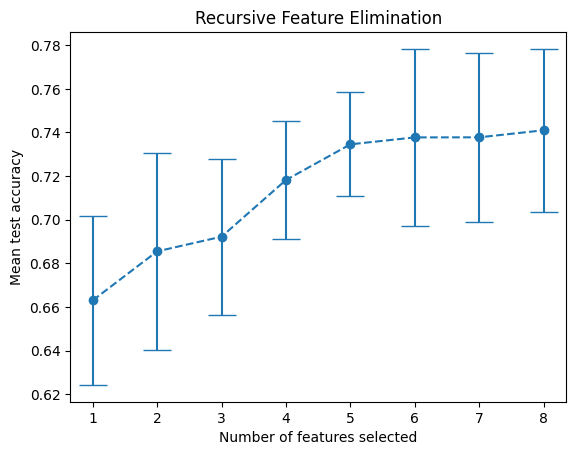

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.errorbar(
    x=cv_results['n_features'],
    y=cv_results['mean_test_score'],
    yerr=cv_results['std_test_score'],
    capsize=10,
    marker='o',
    linestyle='dashed'
)
plt.title('Recursive Feature Elimination')
plt.show()

Not a striking difference between feature sets. They are all within a standard deviation or so of each other. Looks like the sweet spot is around 5 features.

In [19]:
selected_training_features=training_features.to_numpy()
selected_training_features=selected_training_features[:,rfecv.get_support()]

selected_feature_names=[b for a, b in zip(rfecv.get_support(), feature_names) if a]
selected_training_features=pd.DataFrame(data=selected_training_features, columns=selected_feature_names)
selected_training_features.head()

NameError: name 'feature_names' is not defined

In [ ]:
selected_training_features.info()

In [ ]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Feature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

### 2.4. Results

Let's take a look at how we are doing so far by plotting the cross-validation results we have collected.

In [ ]:
import seaborn as sns

def plot_cross_validation(title: str, results: dict) -> plt:
    '''Takes a list of dictionary of cross validation results
    plots as horizontal box-and-whiskers plot. Returns plot
    object.'''

    box_plot=sns.boxplot(
        data = pd.DataFrame.from_dict(results),
        orient = 'h'
    )

    medians=[]

    for scores in results.values():
        medians.append(np.median(scores))

    for ytick in box_plot.get_yticks():
        box_plot.text(medians[ytick],ytick,f'{medians[ytick]:.1f}%', 
                horizontalalignment='center',size='x-small',color='black',weight='semibold',
                bbox=dict(facecolor='gray', edgecolor='black'))
    
    plt.title(title)
    plt.xlabel('Accuracy (%)')


    return plt

In [ ]:
plot_cross_validation('Feature engineering experiments', experiments).show()

### 2.5. Follow-up experiments

Just for fun, let's try some combinations of the above strategies before we move on. For example, what happens if we do imputation and then feature selection?

#### 2.5.1. Impute, then select features

In [ ]:
min_features_to_select=1
clf=DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv_method,
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

rfecv.fit(imputed_training_features, training_labels)

print(f"Optimal number of features: {rfecv.n_features_}")

In [ ]:
imputed_selected_training_features=imputed_training_features.to_numpy()
imputed_selected_training_features=imputed_selected_training_features[:,rfecv.get_support()]

imputed_selected_feature_names=[b for a, b in zip(rfecv.get_support(), feature_names) if a]
imputed_selected_training_features=pd.DataFrame(data=imputed_selected_training_features, columns=imputed_selected_feature_names)
imputed_selected_training_features.head()

In [ ]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    imputed_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Iterative imputation,\nfeature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

#### 2.5.2 Select features, then impute

In [ ]:
# First we need a new missing data features list that contains only
# missing data features which were selected by the recursive feature elimination
selected_missing_data_features=[]

for feature in missing_data_features:
    if feature in selected_training_features.columns:
        selected_missing_data_features.append(feature)

# Save the feature names for later - the imputer will return a numpy array
# and we might like to get out Pandas dataframe back
selected_feature_names=selected_training_features.columns

# Make a copy of the training features dataframe, in case we decide that this
# is a bad idea
selected_imputed_training_features=selected_training_features.copy()
selected_imputed_training_features[selected_missing_data_features]=selected_imputed_training_features[selected_missing_data_features].replace({0:np.nan})

# Quantile transform our target features - this is for the imputer, not the decision tree
qt=QuantileTransformer(n_quantiles=10, random_state=0)
qt.fit(selected_imputed_training_features[selected_missing_data_features])
imputed_training_features[selected_missing_data_features]=qt.transform(imputed_training_features[selected_missing_data_features])

# Run the imputation
imp=IterativeImputer(max_iter=100, verbose=True, tol=1e-6, sample_posterior=True)
imp.fit(selected_imputed_training_features)
selected_imputed_training_features=imp.transform(selected_imputed_training_features)

# Convert back to pandas
selected_imputed_training_features=pd.DataFrame(data=selected_imputed_training_features, columns=selected_feature_names)

In [ ]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    imputed_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Feature selection,\niterative imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

In [ ]:
plot_cross_validation('Feature engineering experiments', experiments).show()

## 3. Hyperparameter optimization

Let's try doing this in two stages - first we will try out *criterion*, *splitter* and *class_weight*. These are choices between a few alternative options. Once we have the best combination for this dataset we will do a second round for hyperparameters like *tree_dept* which are int or float.

In [ ]:
# Start new results holder for hyperparameter optimization results
hyperparameter_experiments={
    'Baseline': experiments['Baseline'],
    'Feature selection': experiments['Feature selection']
}

### 3.1: *Criterion*, *splitter* & *class_weight*

In [ ]:
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV

model=DecisionTreeClassifier(random_state=random_seed)

distributions={
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced']
}

grid=GridSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    return_train_score=True
)

results=grid.fit(training_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

**[Scikit-learn defaults](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)**

1. *criterion='gini'*
2. *splitter='best'*
3. *class_weight=None*

In [ ]:
def plot_hyperparameter_tuning(results: dict) -> plt:
    '''Takes RandomizedSearchCV result object, plots cross-validation
    train and test scores for each fold.'''

    results=pd.DataFrame(results.cv_results_)
    sorted_results=results.sort_values('rank_test_score')

    plt.title('Hyperparameter optimization')
    plt.xlabel('Parameter set rank')
    plt.ylabel('Accuracy')
    plt.gca().invert_xaxis()

    plt.fill_between(
        sorted_results['rank_test_score'],
        sorted_results['mean_test_score'] + sorted_results['std_test_score'], # pylint: disable=line-too-long
        sorted_results['mean_test_score'] - sorted_results['std_test_score'], # pylint: disable=line-too-long
        alpha = 0.5
    )

    plt.plot(
        sorted_results['rank_test_score'],
        sorted_results['mean_test_score'],
        label = 'Validation'
    )

    plt.fill_between(
        sorted_results['rank_test_score'],
        sorted_results['mean_train_score'] + sorted_results['std_train_score'], # pylint: disable=line-too-long
        sorted_results['mean_train_score'] - sorted_results['std_train_score'], # pylint: disable=line-too-long
        alpha = 0.5
    )

    plt.plot(
        sorted_results['rank_test_score'],
        sorted_results['mean_train_score'],
        label = 'Training'
    )

    plt.legend(loc = 'best', fontsize = 'x-small')

    return plt

In [ ]:
plot_hyperparameter_tuning(results).show()

In [ ]:
# Instantiate a model using the winning parameters
model=DecisionTreeClassifier(
    class_weight=results.best_params_['class_weight'],
    criterion=results.best_params_['criterion'],
    splitter=results.best_params_['splitter'],
    random_state=random_seed
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 1']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

In [ ]:
plot_cross_validation('Hyperparameter optimization experiments', hyperparameter_experiments).show()

### 3.2: Other hyperparameters

In [ ]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

model=DecisionTreeClassifier(random_state=random_seed)

distributions={
    'max_depth': list(range(1, 50)),
    'min_samples_split': list(range(5, 50)),
    'min_samples_leaf': list(range(5, 50)),
    'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    'max_features': uniform(loc=0, scale=1),
    'min_impurity_decrease': uniform(loc=0, scale=1)
}

grid=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    n_iter=200,
    random_state=random_seed,
    return_train_score=True
)

results=grid.fit(training_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

In [ ]:
plot_hyperparameter_tuning(results).show()

In [ ]:
# Instantiate a model using the winning parameters
model=DecisionTreeClassifier(
    max_depth=results.best_params_['max_depth'],
    max_features=results.best_params_['max_features'],
    min_impurity_decrease=results.best_params_['min_impurity_decrease'],
    min_samples_leaf=results.best_params_['min_samples_leaf'],
    min_samples_split=results.best_params_['min_samples_split'],
    min_weight_fraction_leaf=results.best_params_['min_weight_fraction_leaf'],
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 2']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

In [ ]:
plot_cross_validation('Hyperparameter optimization experiments', hyperparameter_experiments).show()

## 4. Evaluation

In [ ]:
# Get features and labels
testing_labels=testing_df['Outcome']
testing_features=testing_df.drop('Outcome', axis=1)

In [ ]:
# Fit the model on the feature selected training data
model.fit(training_features, training_labels)

# Make predictions from test set features
predicted_labels=model.predict(testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')